In [1]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
sns.set_context('talk')

In [2]:
sgd_hb = pd.read_csv('../../logs/vgg16_cifar10_constant_epsilon.csv')

In [3]:
sgd_hb.columns=['optimizer', 'initial learning rate', 1,2,3,4,5,'mean','std']
sgd_hb.replace({'HB': 'Heavy Ball\n(HB)'}, inplace=True)

In [4]:
sgd_hb.drop(0, inplace=True)

In [5]:
sgd_hb['optimizer'] = sgd_hb['optimizer'].ffill()

In [6]:
sgd_hb = sgd_hb.dropna()

In [7]:
sgd_hb_melted = pd.melt(sgd_hb, id_vars=['optimizer', 'initial learning rate'], value_vars=[1,2,3,4,5])

In [8]:
sgd_hb_melted.rename(columns={'variable':'seed', 'value':'accuracy'}, inplace=True)

In [9]:
sgd_hb_melted['accuracy'] = sgd_hb_melted['accuracy'].astype(float)

In [10]:
max_locs = sgd_hb_melted.groupby(['optimizer', 'initial learning rate'])['accuracy'].mean().reset_index().groupby('optimizer')['accuracy'].idxmax()

In [11]:
maxes = sgd_hb_melted.groupby(['optimizer', 'initial learning rate'])['accuracy'].mean().reset_index().loc[max_locs.values]

In [12]:
sgd_hb_plot = pd.melt(sgd_hb.loc[max_locs], id_vars=['optimizer', 'initial learning rate'], value_vars=[1,2,3,4,5])

In [13]:
adam = pd.read_csv('../../logs/vgg16_cifar10_varying_epsilon.csv')

In [14]:
adam.columns = ['epsilon', 'initial learning rate', 1,2,3,4,5,'mean','std']

In [15]:
adam.drop(0, inplace=True)
adam.drop(1, inplace=True)
adam.drop(2, inplace=True)
adam.drop(3, inplace=True)

In [16]:
adam['epsilon'].ffill(inplace=True)

In [17]:
adam = adam[adam.apply(pd.to_numeric, errors='coerce').notna().all(axis=1)]

In [18]:
adam.reset_index(drop=True, inplace=True)

In [19]:
adam[['epsilon', 'initial learning rate', 1,2,3,4,5]] = adam[['epsilon', 'initial learning rate',1,2,3,4,5]].astype(float)
adam['Ours'] = adam.loc[:,'epsilon'] > 1

In [20]:
adam = adam.sort_values(by=['epsilon', 'initial learning rate']).reset_index(drop=True)

In [21]:
adam['mean'] = adam[[1,2,3,4,5]].mean(axis=1)
adam_to_plot = adam.loc[adam.groupby('Ours')['mean'].idxmax().values]

In [22]:
to_concat = pd.melt(adam_to_plot, id_vars=['Ours'], value_vars=[1,2,3,4,5])

In [23]:
to_concat = to_concat.rename(columns={'Ours':'optimizer'})
to_concat['optimizer'].replace({False:'Adam:\nHPO Config. 1', True:'Adam:\nHPO Config. 2'}, inplace=True)

In [24]:
plot = pd.concat([sgd_hb_plot, to_concat])
plot.rename(columns={'optimizer':'Optimizer', 'value':'Accuracy'}, inplace=True)
plot['Accuracy'] = plot["Accuracy"].astype(float)

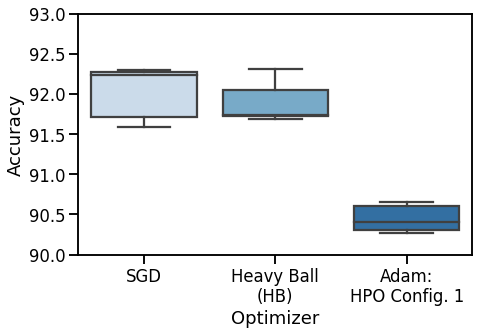

In [25]:
f, ax = plt.subplots(figsize=[7,5])
sns.boxplot(data=plot[plot['Optimizer']!='Adam:\nHPO Config. 2'],x='Optimizer', y='Accuracy',palette='Blues')
plt.ylim([90,93])
plt.tight_layout()
plt.savefig('VGG_HPO_Plot1.pdf')

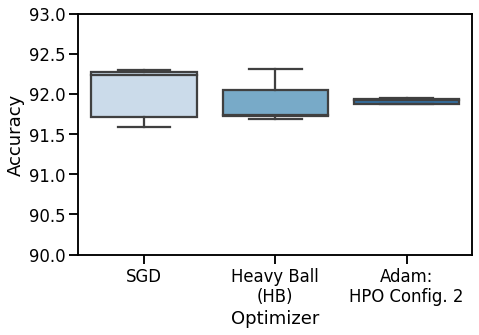

In [26]:
f, ax = plt.subplots(figsize=[7,5])
sns.boxplot(data=plot[plot['Optimizer']!='Adam:\nHPO Config. 1'],x='Optimizer', y='Accuracy',palette='Blues')
plt.ylim([90,93])
plt.tight_layout()
plt.savefig('VGG_HPO_Plot2.pdf')

In [27]:
adam['e_epsilon'] = adam['epsilon'].apply(lambda x: '{:.0e}'.format(x))

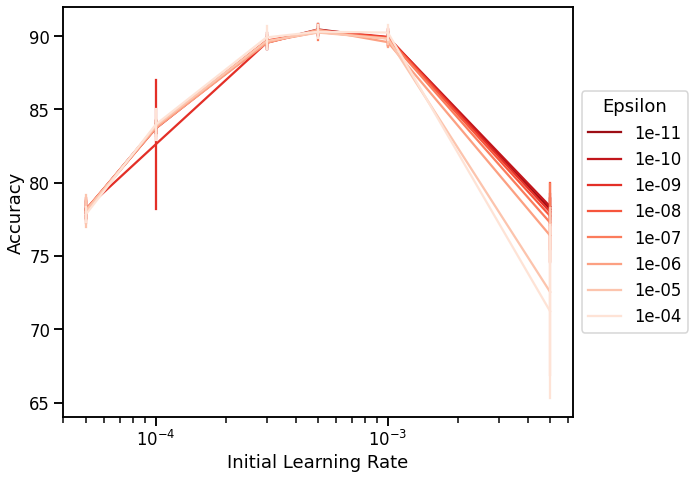

In [28]:
f, ax = plt.subplots(figsize=[10,7])
sns.lineplot(data=pd.melt(adam[~adam['Ours']], id_vars=['e_epsilon', 'initial learning rate'],
                         value_vars=[1,2,3,4,5]), x='initial learning rate', y='value', hue='e_epsilon',
            palette='Reds_r', err_style='bars', markers='.', errorbar=("sd", 2))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Epsilon')
plt.ylabel('Accuracy')
plt.ylim([64, 92])
plt.xscale("log")
plt.xlabel('Initial Learning Rate')
plt.tight_layout()
plt.savefig('full_wilson_results.pdf')

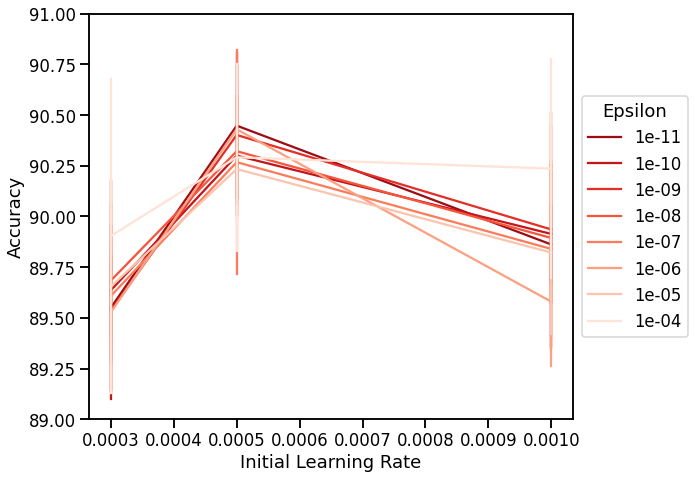

In [29]:
f, ax = plt.subplots(figsize=[10,7])
sns.lineplot(data=pd.melt(adam[np.logical_and(~adam['Ours'], adam[[1,2,3,4,5]].mean(axis=1) > 87)], id_vars=['e_epsilon', 'initial learning rate'],
                         value_vars=[1,2,3,4,5]), x='initial learning rate', y='value', hue='e_epsilon',
            palette='Reds_r', err_style='bars', markers='.', errorbar=("sd", 2))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Epsilon')
plt.ylabel('Accuracy')
plt.ylim([89, 91])
#plt.xscale("log")
plt.xlabel('Initial Learning Rate')
plt.tight_layout()
plt.savefig('sota_wilson_results.pdf')



In [30]:
adam['scaled_lr'] = adam['initial learning rate'] / adam['epsilon']

In [31]:
adam['e_lr'] = adam['initial learning rate'].apply(lambda x: '{:.0e}'.format(x))
adam['e_slr'] = adam['scaled_lr'].apply(lambda x: '{:.0e}'.format(x))


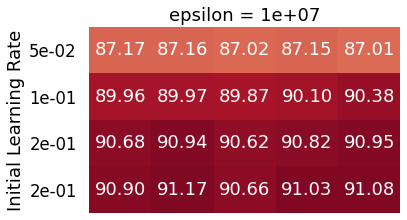

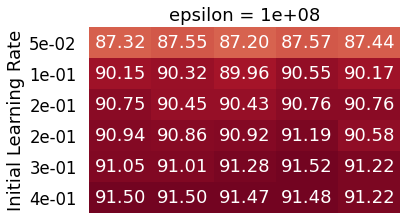

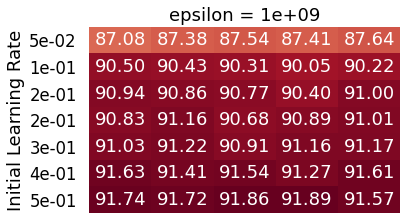

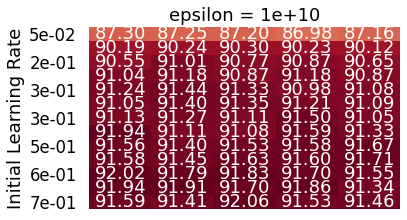

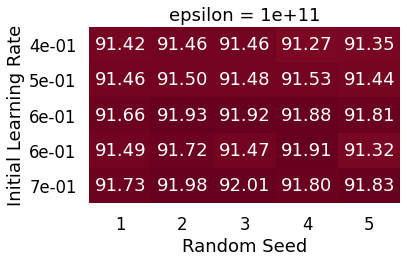

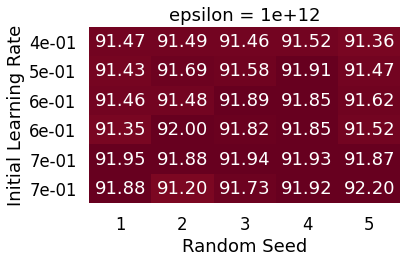

In [32]:
for i, epsilon_val in enumerate(adam[adam['Ours']]['e_epsilon'].unique()):
    if i > len(adam[adam['Ours']]['e_epsilon'].unique()) - 3:
        f, ax = plt.subplots(figsize=[6,4])
    else:
        f, ax = plt.subplots(figsize=[6,3.4])
    sns.heatmap(adam[adam['Ours']][adam[adam['Ours']]['e_epsilon'] == epsilon_val]\
    .set_index('e_slr')[[1,2,3,4,5]], annot=True, cmap="RdBu_r", cbar=False, fmt='.2f', norm=LogNorm(vmin=adam['mean'].min(), vmax=adam['mean'].max()),
    vmin=adam['mean'].min(), vmax=adam['mean'].max())
    plt.ylabel('Initial Learning Rate')
    plt.title('epsilon = {}'.format(epsilon_val))
    if i > len(adam[adam['Ours']]['e_epsilon'].unique()) - 3:
        plt.xlabel('Random Seed')
    else:
        plt.xlabel('')
        ax.get_xaxis().set_ticks([])
    ax.tick_params(left= False, bottom=False)
    plt.tight_layout()
    plt.savefig('adam_tuned_table_{}.pdf'.format(epsilon_val))

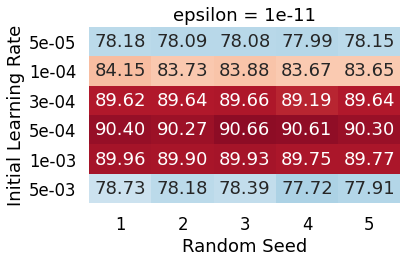

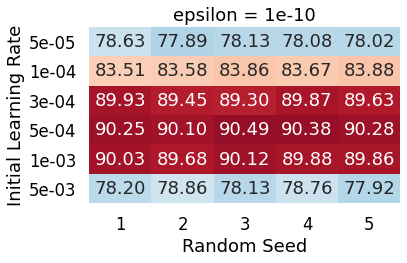

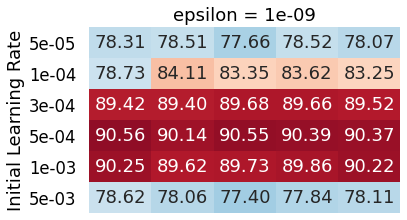

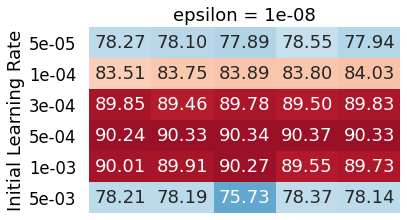

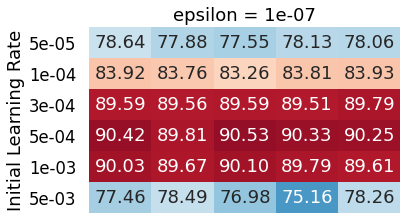

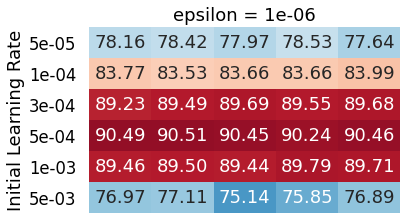

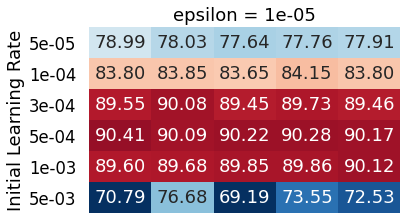

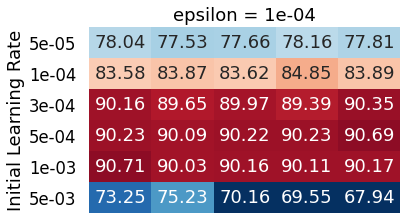

In [33]:
for i, epsilon_val in enumerate(adam[~adam['Ours']]['e_epsilon'].unique()):
    if i < 2:
        f, ax = plt.subplots(figsize=[6,4])
    else:
        f, ax = plt.subplots(figsize=[6,3.4])
    sns.heatmap(adam[~adam['Ours']][adam[~adam['Ours']]['e_epsilon'] == epsilon_val]\
    .set_index('e_lr')[[1,2,3,4,5]], annot=True, cmap="RdBu_r", cbar=False, fmt='.2f', norm=LogNorm(vmin=adam['mean'].min(), vmax=adam['mean'].max()),
    vmin=adam['mean'].min(), vmax=adam['mean'].max())
    plt.title('epsilon = {}'.format(epsilon_val))
    plt.ylabel('Initial Learning Rate')
    ax.tick_params(left= False, bottom=False)
    if i < 2:
        plt.xlabel('Random Seed')
    else:
        plt.xlabel('')
        ax.get_xaxis().set_ticks([])
    plt.tight_layout()
    plt.savefig('adam_tuned_table_{}.pdf'.format(epsilon_val))

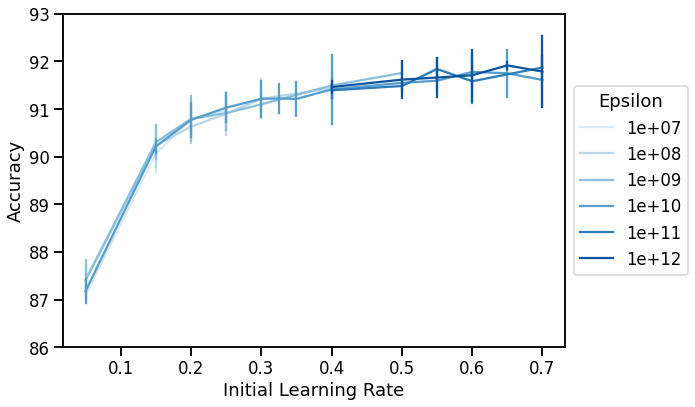

In [34]:
from matplotlib.ticker import ScalarFormatter
f, ax = plt.subplots(figsize=[10,6])
sns.lineplot(data=pd.melt(adam[adam['Ours']], id_vars=['e_epsilon', 'scaled_lr'],
                         value_vars=[1,2,3,4,5]), x='scaled_lr', y='value', hue='e_epsilon',
            palette='Blues', err_style="bars", markers='.', errorbar=("sd", 2))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Epsilon')
plt.ylabel('Accuracy')
plt.ylim([86, 93])
#plt.xscale("log", base=10)
plt.xlabel('Initial Learning Rate')
plt.tight_layout()
plt.savefig('full_our_adam_results.pdf')

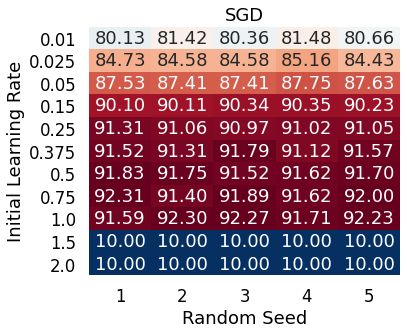

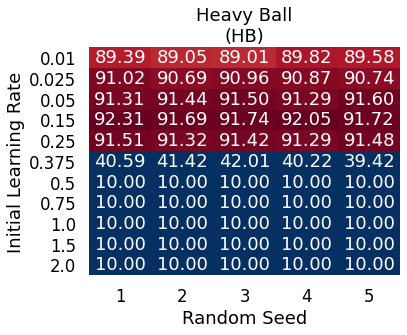

In [35]:
for optimizer in sgd_hb['optimizer'].unique():
    f, ax = plt.subplots(figsize=[6,5])
    sns.heatmap(sgd_hb[sgd_hb['optimizer'] == optimizer].sort_values(by='initial learning rate',inplace=False).set_index('initial learning rate')[[1,2,3,4,5]].astype(float),
                annot=True, cmap="RdBu_r", cbar=False, fmt='.2f', norm=LogNorm(vmin=adam['mean'].min(), vmax=adam['mean'].max()),
    vmin=adam['mean'].min(), vmax=adam['mean'].max())
    ax.tick_params(left= False, bottom=False)
    plt.title(optimizer)
    plt.ylabel('Initial Learning Rate')
    plt.xlabel('Random Seed')
    plt.tight_layout()
    plt.savefig('{}_tuned_table.pdf'.format(optimizer))

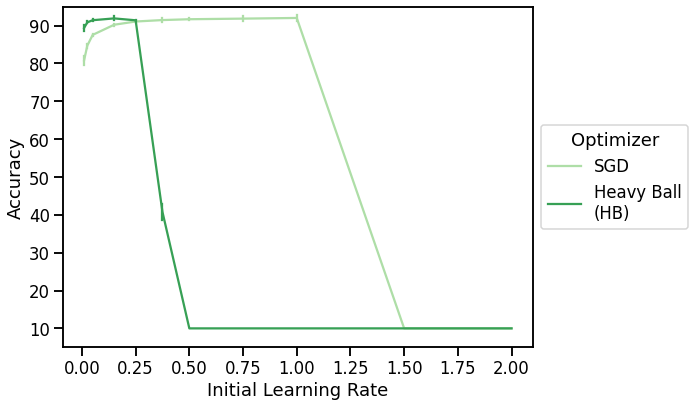

In [36]:
f, ax = plt.subplots(figsize=[10,6])
sgd_hb[[1,2,3,4,5, 'initial learning rate']] = sgd_hb[[1,2,3,4,5, 'initial learning rate']].astype(float)
sns.lineplot(data=pd.melt(sgd_hb, id_vars=['optimizer', 'initial learning rate'], value_vars=[1,2,3,4,5]),
             x='initial learning rate', y='value', hue='optimizer', palette='Greens', err_style="bars", markers='.', errorbar=("sd", 2))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Optimizer')
plt.ylim([5,95])
plt.xlabel('Initial Learning Rate')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('full_sgd_hb_results.pdf')

In [37]:
defense = pd.read_csv('../../logs/new-defense-with-large-eps.csv', index_col=0)

In [38]:
defense_accuracy = defense[['Unnamed: 2', 'Unnamed: 5', 'Unnamed: 8']]

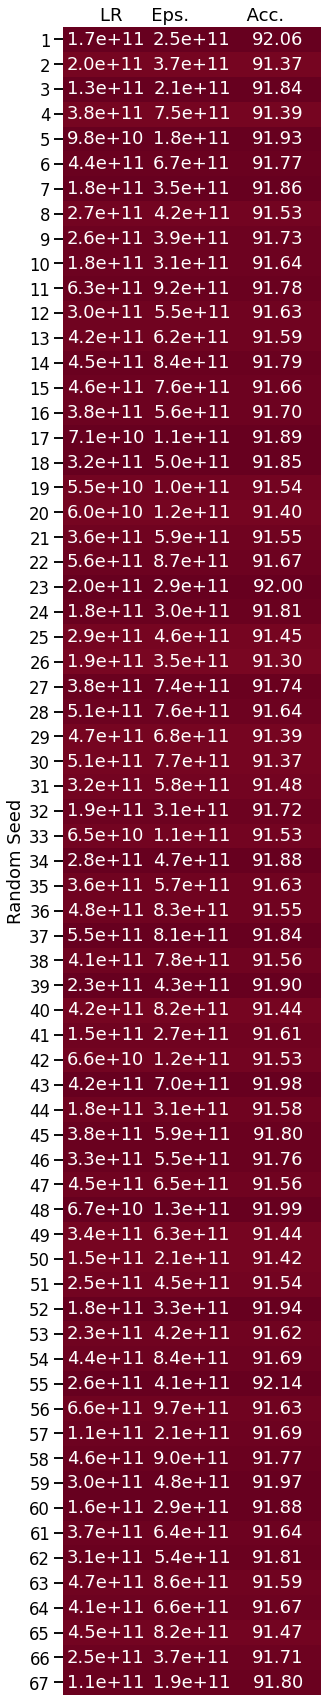

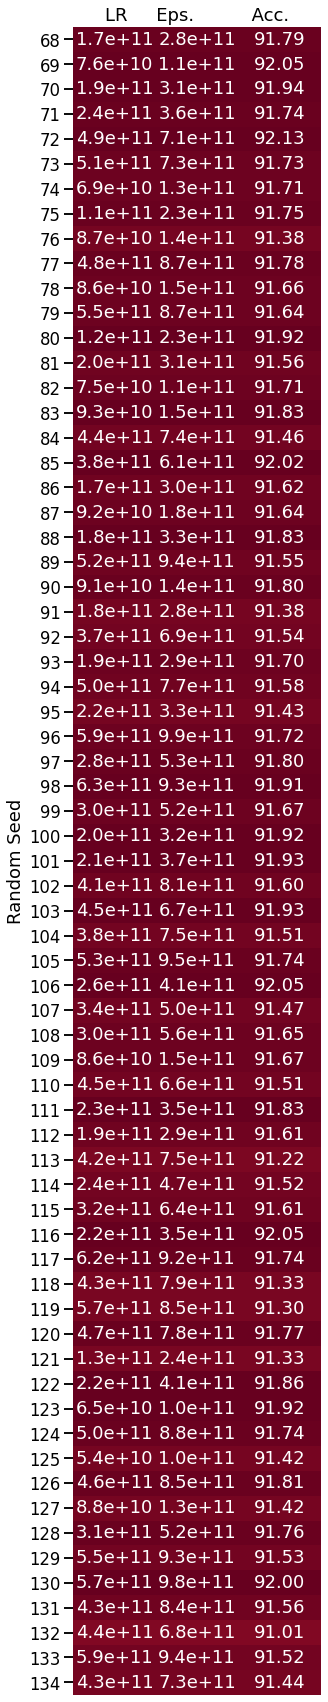

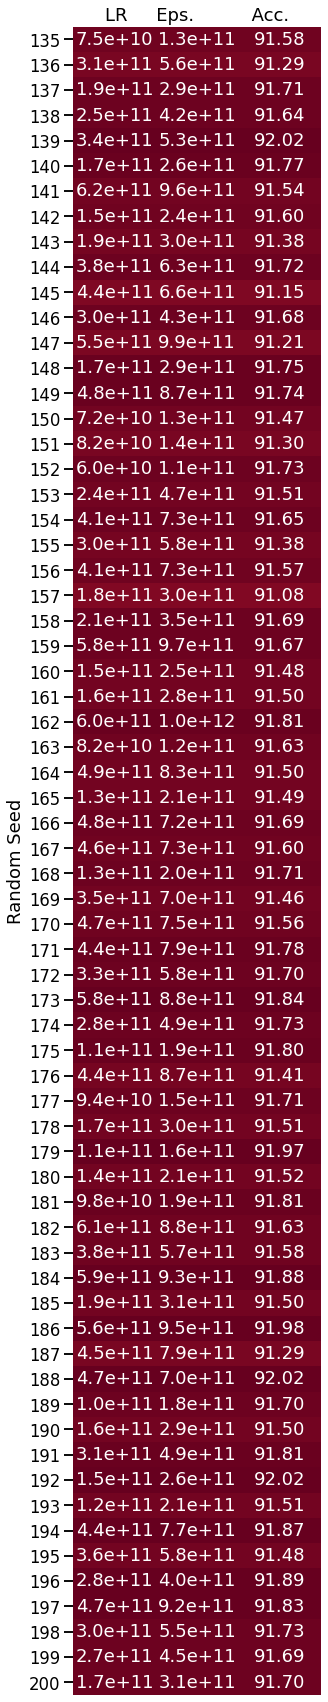

In [39]:
defense_adam = defense[['Adam', 'Unnamed: 7', 'Unnamed: 8']].loc[1:]
defense_adam.columns = ['LR', 'Eps.', 'Acc.']
defense_adam.index = defense_adam.index.astype(int)
defense_adam = defense_adam.astype(float)
defense_adam['LR'] = defense_adam['LR'].apply(lambda x: '{:.1e}'.format(x))
defense_adam['Eps.'] = defense_adam['Eps.'].apply(lambda x: '{:.1e}'.format(x))
defense_adam_heatmap = pd.concat([defense_adam['Acc.'], defense_adam['Acc.'], defense_adam['Acc.']],axis=1)
defense_adam['Acc.'] = defense_adam['Acc.'].apply(lambda x: '{:.2f}'.format(x))
for i in range(3):
    start_loc = (i * 67) + 1
    if i < 2:
        end_loc = (i + 1) * 67
    else:
        end_loc=201
    f, ax = plt.subplots(figsize=[4.9,24])
    sns.heatmap(defense_adam_heatmap.loc[start_loc:end_loc], cmap='RdBu_r',cbar=False, norm=LogNorm(vmin=adam['mean'].min(), vmax=adam['mean'].max()),
        vmin=adam['mean'].min(), vmax=adam['mean'].max(), annot=defense_adam.loc[start_loc:end_loc], fmt='s')
    plt.yticks(rotation = 0)
    plt.ylabel('Random Seed')
    ax.tick_params(bottom=False, labelbottom=False)
    plt.title('LR     Eps.          Acc.')
    plt.tight_layout()
    plt.savefig('defense_adam_{}_{}.pdf'.format(start_loc,end_loc))

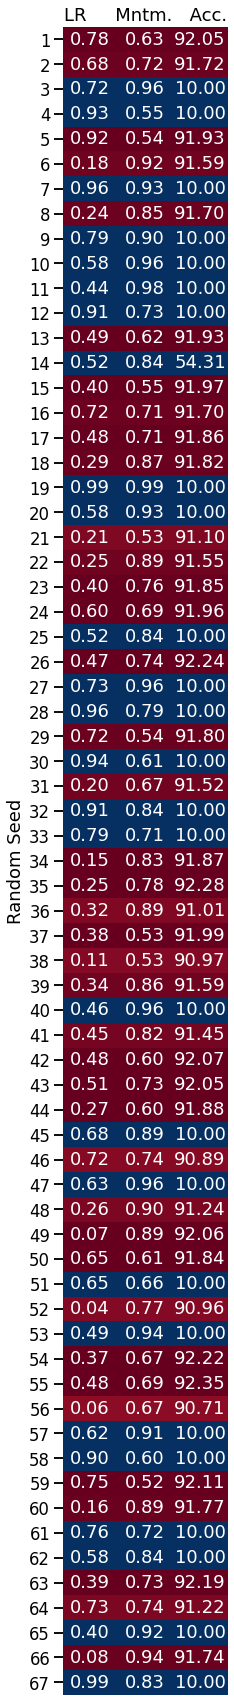

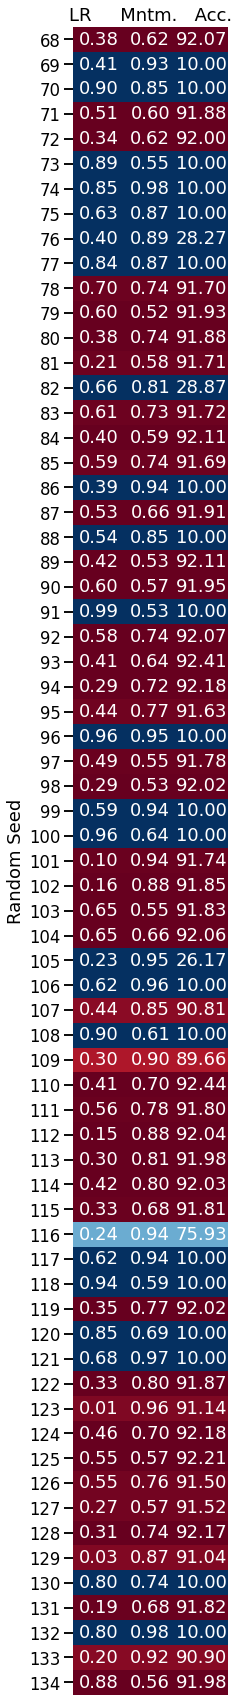

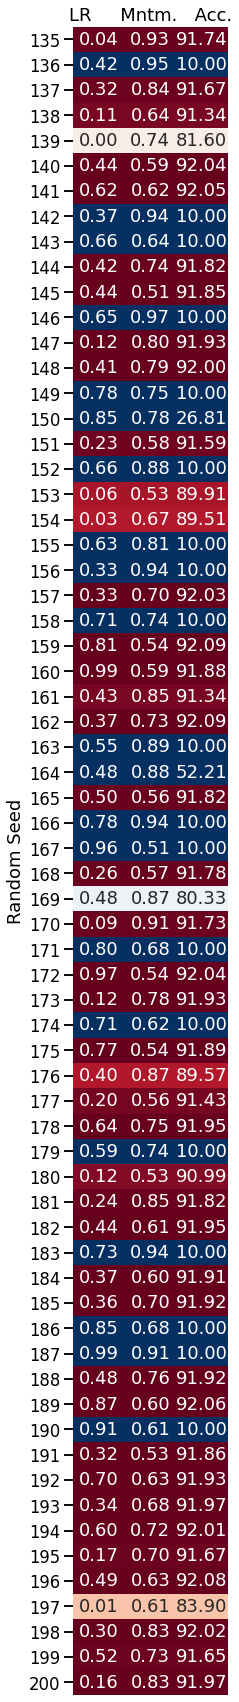

In [40]:
defense_hb = defense[['HB', 'Unnamed: 4', 'Unnamed: 5']].loc[1:]
defense_hb.columns = ['LR', 'Mntm.', 'Acc.']
defense_hb.index = defense_hb.index.astype(int)
defense_hb = defense_hb.astype(float)
defense_hb_heatmap = pd.concat([defense_hb['Acc.'], defense_hb['Acc.'], defense_hb['Acc.']],axis=1)
for i in range(3):
    start_loc = (i * 67) + 1
    if i < 2:
        end_loc = (i + 1) * 67
    else:
        end_loc=201
    f, ax = plt.subplots(figsize=[3.6,24])
    sns.heatmap(defense_hb_heatmap.loc[start_loc:end_loc], cmap='RdBu_r',cbar=False, norm=LogNorm(vmin=adam['mean'].min(), vmax=adam['mean'].max()),
        vmin=adam['mean'].min(), vmax=adam['mean'].max(), annot=defense_hb.loc[start_loc:end_loc], fmt='.2f')
    plt.yticks(rotation = 0)
    plt.ylabel('Random Seed')
    ax.tick_params(bottom=False, labelbottom=False)
    plt.title('LR     Mntm.   Acc.')
    plt.tight_layout()
    plt.savefig('defense_hb_{}_{}.pdf'.format(start_loc,end_loc))

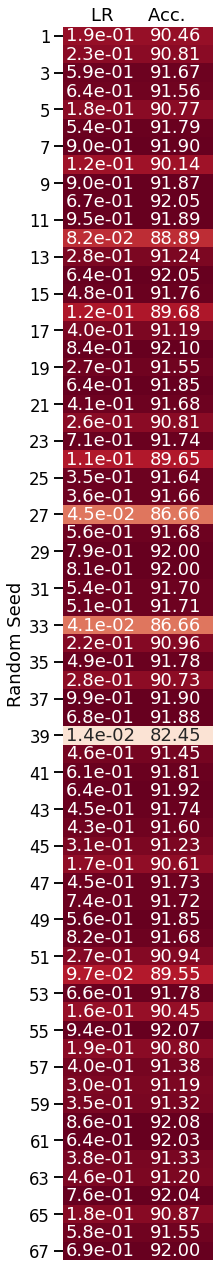

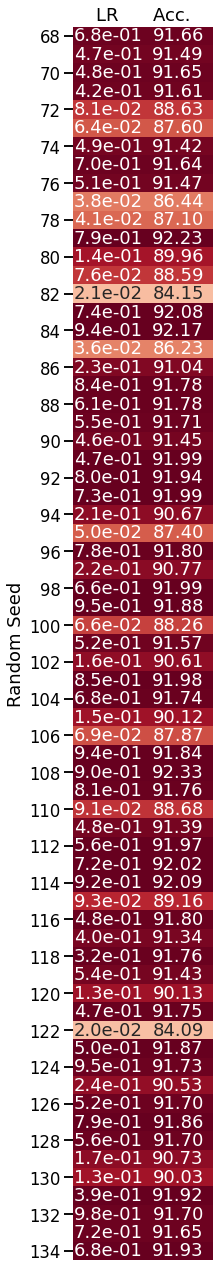

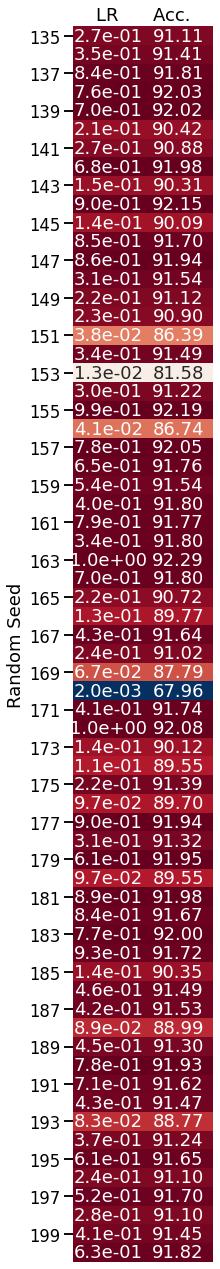

In [41]:
defense_sgd = defense[['SGD', 'Unnamed: 2']]
defense_sgd.columns = ['LR', 'Acc.']
defense_sgd = defense_sgd.iloc[1:]
defense_sgd.index = defense_sgd.index.astype(int)
defense_sgd = defense_sgd.astype(float)
defense_sgd_heatmap = pd.concat([defense_sgd['Acc.'],defense_sgd['Acc.']],axis=1)
defense_sgd_heatmap.columns = ['LR', 'Acc.']
defense_sgd_heatmap = defense_sgd_heatmap.astype(float)
defense_sgd['LR'] = defense_sgd['LR'].apply(lambda x: '{:.1e}'.format(x))
defense_sgd['Acc.'] = defense_sgd['Acc.'].apply(lambda x: '{:.2f}'.format(x))
for i in range(3):
    start_loc = (i * 67) + 1
    if i < 2:
        end_loc = (i + 1) * 67
    else:
        end_loc=201
    f, ax = plt.subplots(figsize=[3.4,18])
    sns.heatmap(defense_sgd_heatmap.loc[start_loc:end_loc], cmap='RdBu_r',cbar=False, norm=LogNorm(vmin=adam['mean'].min(), vmax=adam['mean'].max()),
        vmin=adam['mean'].min(), vmax=adam['mean'].max(), annot=defense_sgd.loc[start_loc:end_loc], fmt='s')
    plt.yticks(rotation = 0)
    plt.ylabel('Random Seed')
    ax.tick_params(bottom=False, labelbottom=False)
    plt.title('LR      Acc.')
    plt.tight_layout()
    plt.savefig('defense_sgd_{}_{}.pdf'.format(start_loc,end_loc))

In [42]:
defense_accuracy.columns = ['SGD', 'Heavy Ball (HB)', 'Adam']
defense_accuracy = defense_accuracy.loc[1:]
defense_accuracy.index = defense_accuracy.index.astype(int)

In [43]:
hb_wins = defense_accuracy['Adam'] <  defense_accuracy['Heavy Ball (HB)']

In [44]:
sgd_wins = defense_accuracy['Adam'] <  defense_accuracy['SGD']

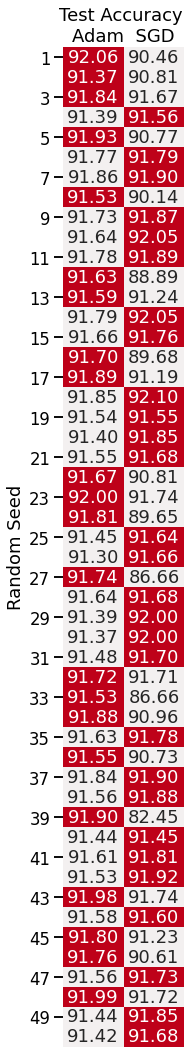

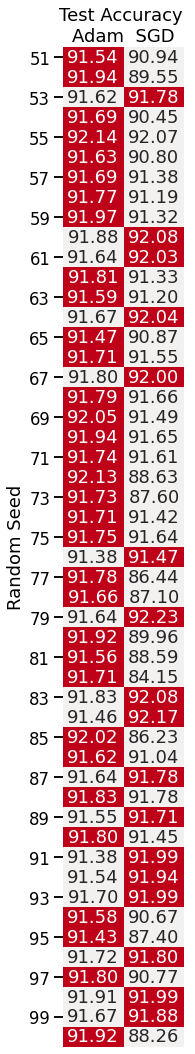

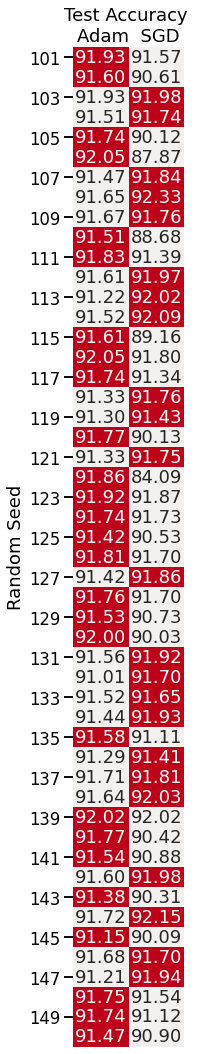

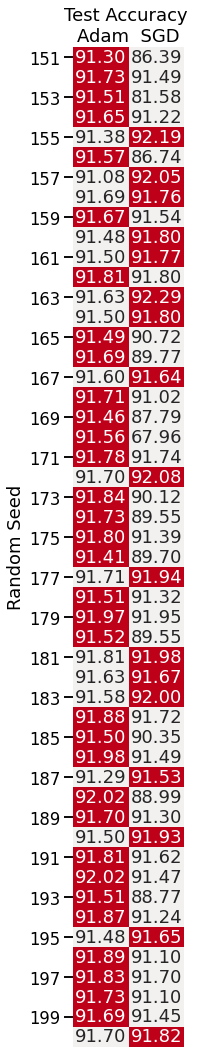

In [45]:
for i in range(4):
    start_loc = (i * 50) + 1
    end_loc = (i + 1) * 50
    f, ax = plt.subplots(figsize=[3,15])
    sns.heatmap(pd.DataFrame([~sgd_wins, sgd_wins]).T.loc[start_loc :end_loc],
            cmap=sns.light_palette("#be0119", as_cmap=True),
            fmt='.2f', annot=defense_accuracy[['Adam', 'SGD']].astype(float).loc[start_loc:end_loc], cbar=False)
    plt.yticks(rotation = 0)
    plt.ylabel('Random Seed')
    ax.tick_params(bottom=False, labelbottom=False)
    plt.title('Test Accuracy \nAdam  SGD')
    plt.tight_layout()
    plt.savefig('adam_sgd_defense_test_{}_{}.pdf'.format(start_loc, end_loc))

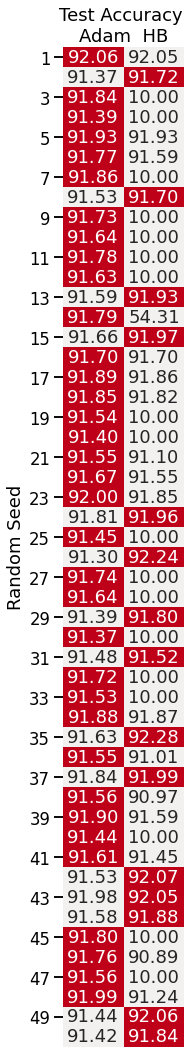

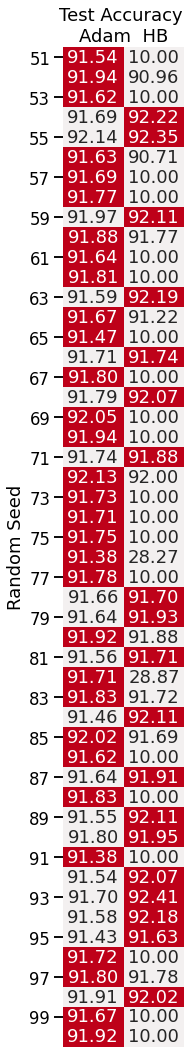

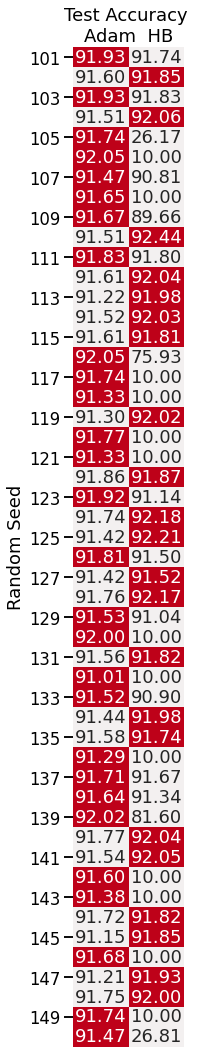

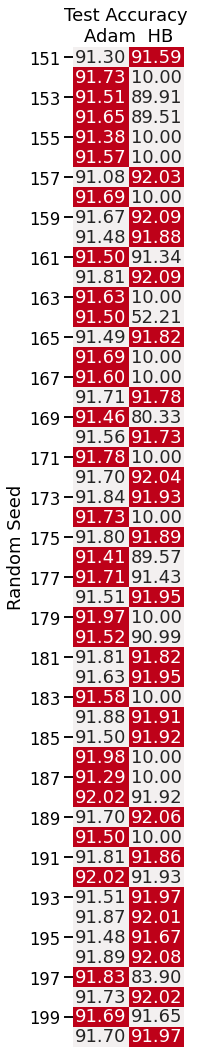

In [46]:
for i in range(4):
    start_loc = (i * 50) + 1
    end_loc = (i + 1) * 50
    f, ax = plt.subplots(figsize=[3,15])
    sns.heatmap(pd.DataFrame([~hb_wins, hb_wins]).T.loc[start_loc :end_loc],
            cmap=sns.light_palette("#be0119", as_cmap=True),
            fmt='.2f', annot=defense_accuracy[['Adam', 'Heavy Ball (HB)']].astype(float).loc[start_loc:end_loc], cbar=False)
    plt.yticks(rotation = 0)
    plt.ylabel('Random Seed')
    ax.tick_params(bottom=False, labelbottom=False)
    plt.title('Test Accuracy \nAdam  HB')
    plt.tight_layout()
    plt.savefig('adam_hb_defense_test_{}_{}.pdf'.format(start_loc, end_loc))